# Visualizations 

In [18]:
# Libraries
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
from matplotlib import cm as color_map
import models as m
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.utils import save_image
from tqdm import tqdm

%matplotlib inline

# Set reproducibility seeed
torch.manual_seed(512)
plt.style.use("ggplot")

BATCH_SIZE = 128

## Histogram with pixel values for MNIST data set

This might justify the use of the Bernoulli distribution for the decoder even if the data is not binary. We do however notice that most of the pixels values are either $0$ or $1$.

In [19]:
# Step 1: Define the transform to convert the image to a float tensor
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


## MNIST Preprocessing as described in Appendix 4
# Add custom transformation that adds uniform [0,1] noise
# to the integer pixel values between 0 and 255 and then
# divide by 256, to obtain values in [0,1]
class AddNoiseToTensor(object):
    def __call__(self, pic):
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return (tensor + torch.rand(tensor.size())).div(256.0)


# Step 2: Load the MNIST dataset
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Step 3: Combine training and testing datasets
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Step 4: Create a DataLoader to batch the data for efficient processing
data_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 5: Collect all pixel values
pixel_values = []

for batch_idx, (data, target) in tqdm(enumerate(data_loader)):
    # data shape is [batch_size, 1, 28, 28]
    # Flatten the data to [batch_size, 784]
    data = data.view(data.size(0), -1)
    # Convert to NumPy and extend the pixel_values list
    pixel_values.extend(data.numpy().flatten())

# Convert the list to a numpy array
pixel_values = np.array(pixel_values)

# Step 6: Define bins from 0 to 1 with bin size 0.05
bins = np.arange(0, 1.05, 0.05)  # Includes the endpoint 1.0


547it [00:03, 177.07it/s]


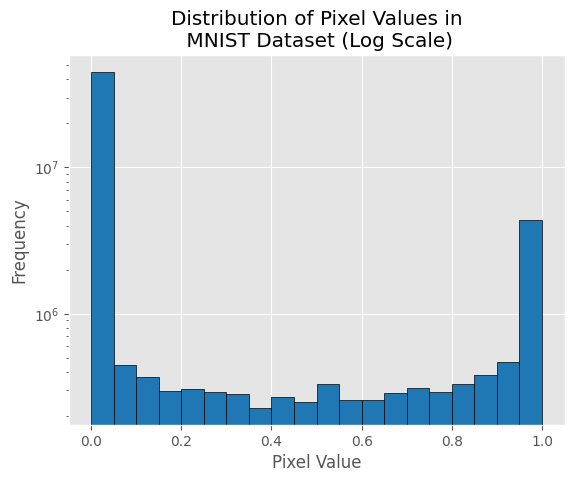

In [20]:
# Step 7: Create the histogram
plt.hist(pixel_values, bins=bins, edgecolor="black", log=True, color="tab:blue")

# Step 8: Add title and labels to the plot
plt.title("Distribution of Pixel Values in\n MNIST Dataset (Log Scale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Step 9: Display the plot
plt.show()

## Qualitative Comparison Between Samples

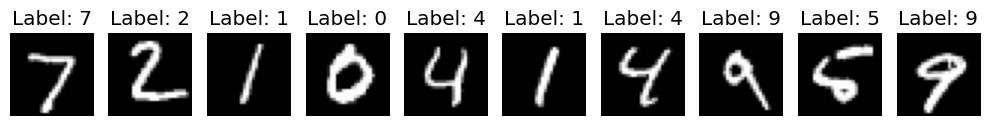

In [21]:
# Visualize dataset
dataiter = iter(test_loader)
mnist_images, mnist_labels = next(dataiter)

images = mnist_images[:10]
labels = mnist_labels[:10]
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for idx in range(10):
    img = np.squeeze(images[idx])
    axes[idx].imshow(img, cmap="gray")
    axes[idx].set_title(f"Label: {labels[idx].item()}")
    axes[idx].axis("off")
plt.tight_layout()
plt.show()

In [22]:
# Visualization of samples from pre-trained models

# Check if cuda available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# Set directory to parent
os.chdir("..")

In [23]:
def imshow(img, title="MNIST Samples"):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")


In [24]:
latent_dim = 2

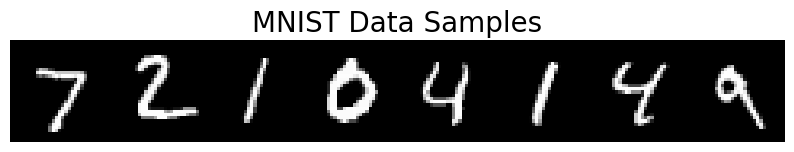

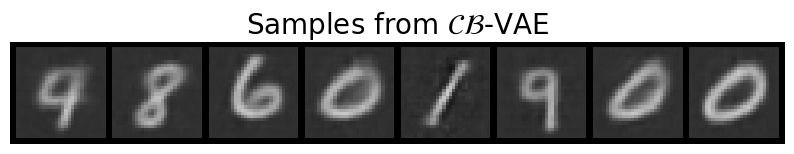

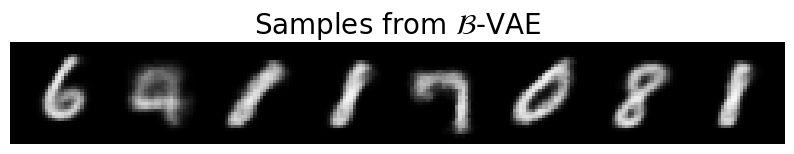

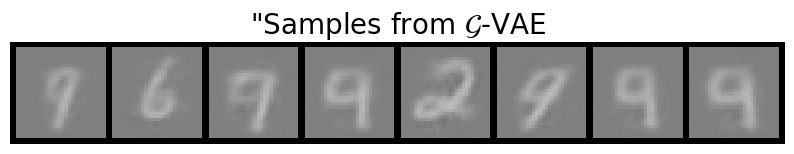

In [37]:
model_vae = m.VAE(latent_dim=latent_dim, distribution="bernoulli").to(device)
model_cbvae = m.VAE(latent_dim=latent_dim, distribution="continuous_bernoulli").to(
    device
)
model_gvae = m.VAE(latent_dim=latent_dim, distribution="gaussian").to(device)


# Load models
model_vae.load_state_dict(
    torch.load("./VAE/models/vae_bernoulli.pt", weights_only=True)
)
model_cbvae.load_state_dict(
    torch.load("./VAE/models/vae_continuous_bernoulli.pt", weights_only=True)
)
model_gvae.load_state_dict(
    torch.load("./VAE/models/vae_gaussian.pt", weights_only=True)
)

# Sample from models
model_vae.eval()
model_cbvae.eval()
model_gvae.eval()

z = torch.randn(8, 2).to(device)
sample_vae = torch.sigmoid(model_vae.decoder(z)).cpu().view(8, 1, 28, 28).detach()
sample_cbvae = torch.sigmoid(model_cbvae.decoder(z)).cpu().view(8, 1, 28, 28).detach()
sample_gvae = torch.sigmoid(model_gvae.decoder(z)).cpu().view(8, 1, 28, 28).detach()


# Plot
num_samples = 8
imshow(
    torchvision.utils.make_grid(mnist_images[:num_samples], num_samples),
    r"MNIST Data Samples",
)
imshow(
    torchvision.utils.make_grid(sample_cbvae[:num_samples], num_samples),
    r"Samples from $\mathcal{CB}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_vae[:num_samples], num_samples),
    r"Samples from $\mathcal{B}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_gvae[:num_samples], num_samples),
    r'"Samples from $\mathcal{G}$-VAE',
)